# Results

The script below runs the model, outputs the results, and generates:
- [Figures 1 & 2: Non-stationarity impacts](#fig1)
- [Dynamic Stress-Yield Relationships](#yields)
- [LGP impacts on yield](#lgp)

Last updated: 29 July 2020

In [1]:
# We need to add the module path to our system path so 
# so that our notebook can find our local objects and code:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
#os.chdir('..')

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

# Uncomment for black background figure
# plt.rcParams.update({
#     "grid.color": "white",
#     'hatch.color': 'k',
#     "lines.color": "white",
#     "patch.edgecolor": "white",
#     'patch.facecolor': ([0, 1, 1]),
#     'grid.alpha': 0.4,
#     "text.color": "lightgray",
#     "axes.facecolor": "black",
#     "axes.edgecolor": "lightgray",
#     "axes.labelcolor": "white",
#     "xtick.color": "white",
#     "ytick.color": "white",
#     "grid.color": "lightgray",
#     "figure.facecolor": "black",
#     "figure.edgecolor": "black",
#     "savefig.facecolor": "black",
#     "savefig.edgecolor": "black"})

/Users/kellycaylor/opt/anaconda3/envs/maize-Toff/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


### Figures 1 and 2 <a id='fig1'></a>

In [ ]:
def figure1a(
        n_sim = 1000, burn_in = 60, station = 'OL JOGI FARM',
        data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv',
        texture = 'clay loam', lgp=180, pd_sim=60):
    """ Set up model conditions for model runs. 

    Usage: figure1a(n_sim, burn_in, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        burn_in = 60 # Number of Days to Run for Initial Conditions Removeal [integer]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]
        data_file = TODO

    """
    ######################### Step 1: Run model
    # Part 1. Set conditions for IC runs
    doy = abs(burn_in - pd_sim) # absolute value

    # Part 2. Initialize model with a climate, soil and crop
    s0_climate = Climate(data_file=data_file, station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=s0_climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=doy)
    models = [CropModel(
                crop=crop,
                climate=Climate(alpha_r=s0_climate.alpha_r, lambda_r=s0_climate.lambda_r),
                soil=soil) 
                  for i in np.arange(n_sim)
             ]
    # Part 4. Run the actual simulations
    planting_date = pd_sim 
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg soil moisture
    start = burn_in 
    end = start + lgp
    avg_s = [df[start:end]['s'].mean() for df in output]
    print('done')
    
    return int(lgp), avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in

lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = figure1a()

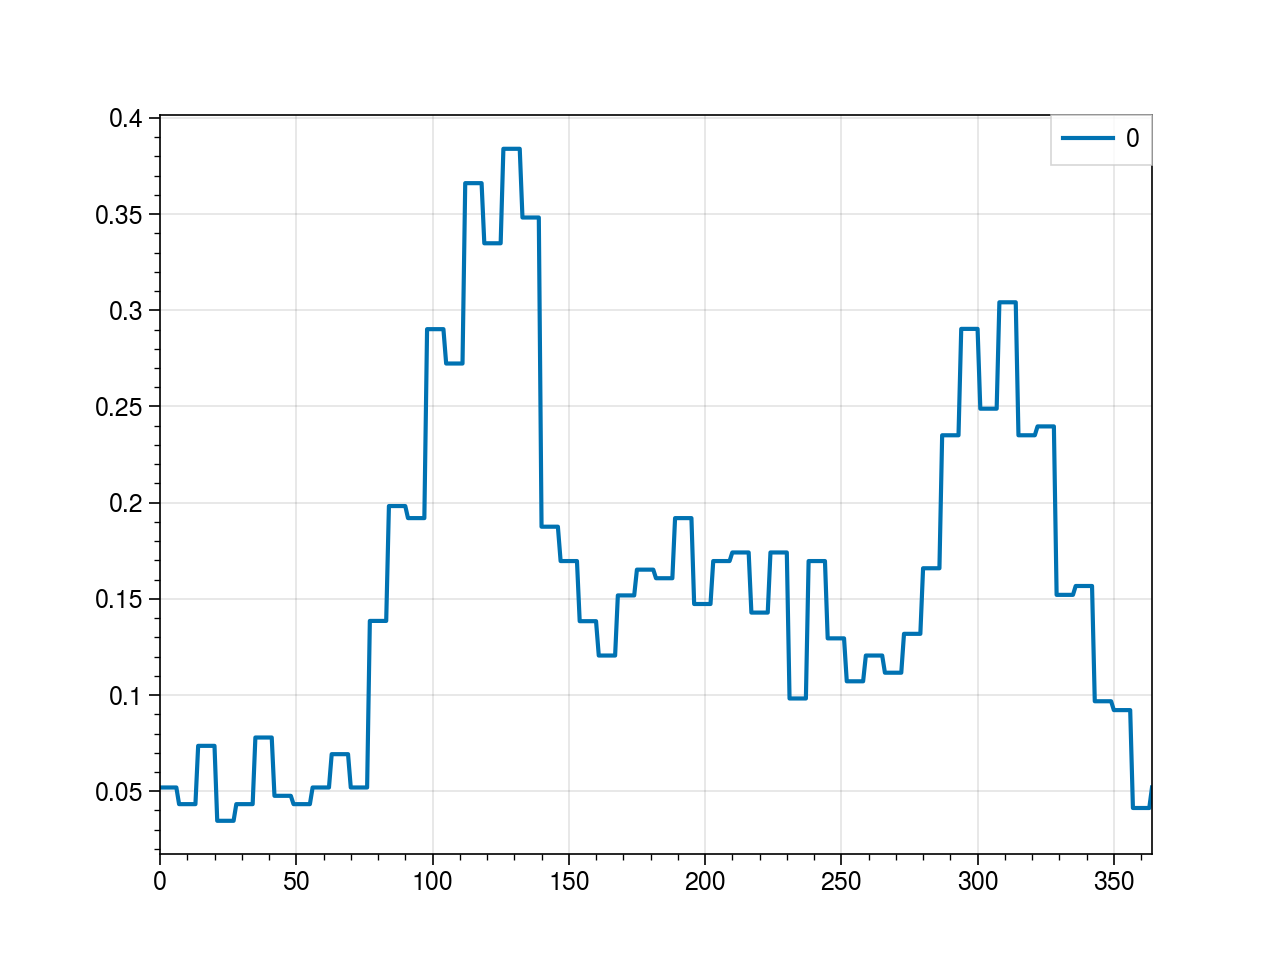

In [4]:
from farm.climate import make_climate_parameters
data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv'
station = 'OL JOGI FARM'
#alphas, lambdas = make_climate_parameters(data_file=data_file, station=station, interval='week')
s0_climate = Climate(data_file=data_file, station=station)
pd.DataFrame(s0_climate.lambda_r).plot()
#climate=Climate(alpha_r=s0_climate.alpha_r, lambda_r=s0_climate.lambda_r)
#pd.DataFrame(climate.rainfall).plot()

In [ ]:
from dateutil.relativedelta import *

data_file=module_path + "/data/CETRAD/CETRAD_rainfall.csv"
df = pd.read_csv(data_file)

format = '%m/%d/%y' # Column RDate has data in M/D/YY
df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

# 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
# Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
# We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
# their value. This requires using the relativedelta function, which handles weird stuff like leap years.
df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

date = df['Datetime'][0]

In [ ]:
date.week

Note for the rainfall time series below, when we do more than 1000+ simulations, we pull out abnormal years where there can be 100 mm in a day. So when we run the final 10,000 time series, just take care to pick a good looking plot for the paper.

In [ ]:
def figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)
        Takes all the outputs from the previous function

    """
    ######################### Step 2: Make figures
    # Part 6. Decide whether using white (publication) or black background (presentation): 
    # for white background
    col='k'
    
    # for black backgroumd
    # col='white'
    
    f, axs = plot.subplots(nrows = 1, ncols = 3, share=0) # journal='agu1', tight=False
    axs.format(
        abc=True, abcloc='ul', suptitle='Model outputs \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
    )
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)

    # TOP FIGURE
    # Do some shenanigans to select a simulation that dips below wilting point
    s_min = []
    no_sims = np.arange(0,n_sim)
    
    for i in no_sims:
        #print(output[i][start:end]['s'].min())
        _s_min = output[i][start:end]['s'].min()
        s_min.append(_s_min)
    result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

    # which simulation has the smallest s value?
    lowest = result[['s_min']].idxmin().item() #result[126:] yup, looks good
    
    # Figure 1a: Rainfall from one simulation
    rf = output[lowest][start:end]['R']
    stress = output[lowest][start:end]['stress']
    
    # Adjust index to account for the fact that python is zero-indexed
    rf.index = rf.index - burn_in-1 # change index so that we can see day of season
    stress.index = stress.index - burn_in-1
    
    axs[0,0].bar(rf, color=col, edgecolor=col) #darkblue, ,
    axs[0,0].format(ylabel='Daily rainfall / mm')
    axs[0,0].format(xlabel='Day of season')
    
    # Figure 1c: stress from one simulation
    axs[0,2].plot(stress, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,2].format(ylabel='Stress')
    #axs[0,1].format(ylim=(0, 1.02)) # xlim=(0, 0.4), 
    axs[0,2].format(xlabel='Day of season')
        
    # Figure 1b: Soil moisture from one simulation
    # convert saturation to volumetric water content:
    # relative saturation*porosity
    # we have the function theta already but I'm not sure that we call on that.
    vwc = output[lowest][start:end]['s']*Soil(texture).n
    
    _sstar = crop.s_star*Soil(texture).n # convert s_star and sw
    _sw = crop.sw*Soil(texture).n
    
    # LEGEND
    hs = []
    cycle = ['-','--']
    var = [_sstar, _sw]
    LABEL = ['Stress point (s*)','Wilting point (sw)']
    
    for item, cycle, LABEL in zip(var, cycle, LABEL):
        h = axs[0,1].axhline(y=item, lw=1, color='r', linestyle=cycle, label=LABEL)
        hs.append(h)
    
    f.legend(hs, loc='right', ncols=1, frame=True)
    
    # Adjust index to account for the fact that python is zero-indexed
    vwc.index = vwc.index - burn_in-1 # need the time series to start at day 1 not day 61
    
    axs[0,1].plot(vwc, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,1].format(ylabel='Volumetric water content / mm')
    axs[0,1].format(xlabel='Day of season')
    plt.savefig(module_path + '/output/figures/fig1.png',format='png')
    
    # Figure 2
    f, axs = plot.subplots(nrows=2, ncols=2, share=0, journal='agu4')
    axs.format(abc=True, abcloc='ul') # suptitle='Figure 2'
    
    # Figure a: Soil moisture distribution - converted
    ax = axs[0,0]
    avg_s = np.array(avg_s)*Soil(texture).n
    sns.distplot(avg_s, ax=ax, color=col, **{'kde': True, 'hist': True}) # hist_kws={"color": 'gainsboro'}
    #ax.format(xlim=(0.2, 0.5), ylim=(0, 15))
    ax.format(ylabel=r'p($\overline{vwc}$)')
    ax.format(xlabel='Volumetric Water Content (mm)')
    
    # Figure c: Stress distribution
    ax = axs[1,0]
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    sns.distplot(avg_stress, ax=ax, color=col,**{'kde': True, 'hist': True}) # hist_kws={"color": 'black'
     
    #ax.format(xlim=(-0.1, 0.9), ylim=(0, 10))
    ax.format(ylabel=r'p($\overline{stress}$)')
    ax.format(xlabel='Stress')
    
    # Figure b: Soil moisture time series - need to convert this one
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1)
    avg_daily = avg_daily*Soil(texture).n
    avg_daily_t = avg_daily.T
    daily_mean = avg_daily.mean(axis=1)
    
    daily_mean.index = daily_mean.index - burn_in-1 # Change index so that we can see day of season
    data = np.array(daily_mean)
    axs[0,1].plot(daily_mean, color=col, lw=2)

    x = np.arange(1, len(daily_mean)+1, 1) 

    quant = avg_daily_t.quantile([.1, .9])
    quant = quant.T
    axs[0,1].fill_between(x, quant[0.1], quant[0.9]) # ,facecolor='gainsboro'
    axs[0,1].format(ylim=(0.2, 0.5)) #xlim=(0.3, 0.8), 
    axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(ylabel='Volumetric Water Content / mm')
    
    # Figure f: stress time series
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean.index = daily_mean.index - burn_in-1 
    axs[1,1].plot(daily_mean, color=col, lw=2)

    x = np.arange(1, len(daily_mean)+1, 1) 
    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[1,1].fill_between(x, quant[0.1], quant[0.9]) #,facecolor='dimgray'
    axs[1,1].format(ylim=(-0.05, 1))
    plt.ylabel('Stress')
    axs[1,1].format(ylabel='Stress')
    axs[1,1].format(xlabel='Day of season')
    ax.xaxis.label.set_color(col)
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)
    axs.format(
    #rowlabels=['Volumetric Water Content', 'Stress'],
    collabels=['PDF', 'Time Series']
    )
    plt.savefig(module_path + '/output/figures/fig2.png',format='png')
    print('s star',_sstar,'sw',_sw)

figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)

In [ ]:
# need to output the 10,000 simulations into one dataframe (?) for export
# But then also need to truncate just to start and end for each sim.
# Should be able to do that using a for loop.
#pd.concat(output)
#plt.rcParams.keys()

### Dynamic Stress-Yield Relationship <a id='yields'></a>

In [ ]:
# Dynamic Stress Yield Rlxn

def model_runs(n_sim = 1000, burn_in = 60, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    doy = abs(burn_in - pd_sim) # absolute value

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=doy)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    planting_date = pd_sim
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg stress, total rf
    start = burn_in 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]

    # dont need this but helpful for debugging
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    sat = [df[start:end]['s'] for df in output]
    stress = [df[start:end]['stress'] for df in output]
    
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    # prev crop.calc_dstress
    x = [crop.calc_dstress(s=df.s, stress=df.stress) for df in o] #for i in np.arange(n_sim)
    #print(x)
    
    # Part 7. Define kc
    start = burn_in
    end = burn_in + lgp
    kc = o[1][start:end]['kc'].tolist()
    
    return  x, total_rf, sat, stress, o, crop, output, kc, start, end #output, avg_stress, total_stress, total_rf, mstr_memb, dstr_memb, yield_kg_ha

# Note: Not great practice to return all of these variables, but for testing it's useful
data, rf, sat, stress, o, crop, output, kc, start, end = model_runs()

def fig3():
    # Turn dynamic water stress data into a tuple
    df = pd.DataFrame.from_records(data, columns =['AvgStress2','DynamicStress','Yield'])
    df['RF'] = rf

    # We'll be using these variables a lot
    x = df.RF
    y = df.Yield

    # Scatter plot of raw data
    max(df.Yield)

    df['Yield_norm'] = df.Yield/max(df.Yield)

    f, axs = plot.subplots(journal='agu1') #, tight=False
    axs.format(
        abc=False, abcloc='ul', suptitle='Rainfall-Yield Relationship Using Dynamic Stress')
    
    
    plt.scatter(df.RF, df.Yield_norm) # , color='black'
    plt.ylim(-.10,1.10)
    plt.xlim(100,900)
    #plt.title('Rainfall-Yield Relationship Using Dynamic Stress')
    plt.ylabel('Yield normalized by max. yield')
    plt.xlabel('Rainfall (mm)')
    #plt.savefig('../output/figures/fig3.pdf',format='pdf')
    # New fit
    residuals = plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)')
    
    #power_law_fit(x,y,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')
    # confidence intervals around line?
    
fig3()

def fig4():
    # Do scatter plot with three variety types

    # Now I have to re-run the simulations using the max yields from this relationship

    varieties = np.arange(75,180,5)
    len(varieties)

    result = []

    for i in varieties:
        # note: bumping up to 200 sims per cultivar type takes several minutes to run
        # whereas 100 sims where varieties = np.arange(70,200,5) takes less than a minute.
        data, rf, sat, stress, o, crop, output, kc, start, end = model_runs(n_sim = 100, station = 'OL JOGI FARM', texture = 'clay loam', lgp=i, pd_sim=60)
        df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
        df['RF'] = rf
        df['Cultivar'] = i
        result.append(df)

    result = pd.concat(result)
    result

    # Add categorical values for early, medium and late maturing
    # There is probably a way more efficient way to do this

    def category(x):
        if x < 110:
            return "Early (< 105 d)"
        if 110 <= x <= 140:
            return "Medium (110 - 140 d)"
        else:
            return "Late (145 + d)"

    for row in result.Cultivar:
        result['Category'] = result.Cultivar.apply(lambda x: category(x))

    result.Category.value_counts()

    f, axs = plot.subplots(nrows=1, ncols=3, journal='agu2', spanx=True, tight=True) #, tight=False

    result['Yield_norm'] = result.Yield/max(result.Yield)
    datas = ["Category == 'Early (< 105 d)'", "Category == 'Medium (110 - 140 d)'", "Category == 'Late (145 + d)'"]

    # one option for colors
    #import matplotlib.cm as cm
    #colors = cm.rainbow(np.linspace(0, 1, 3))

    # another option for colors
    red = sns.color_palette("reds")[-2] 
    yellow = sns.color_palette("orange1")[-3]
    blue = sns.color_palette("blues")[-1]
    colors = [red, yellow, blue]

    for ax, data, c in zip(axs, datas, colors):
        dat = result.query(data)
        ax.scatter(dat.RF, dat.Yield_norm, color=c)

    axs.format(xlim=(0, 900), ylim=(-0.05, 1.05), 
        abc=True, xlabel='Rainfall (mm)', ylabel='Yield normalized by max. yield', abcloc='ul', 
               collabels=['Early', 'Medium', 'Late'],
               suptitle='Rainfall-Yield Relationship Using Dynamic Stress (k=0.2, r=0.5)')

    #plt.savefig('../output/figures/yieldrf.png',format='png')
fig4()

### LGP impacts on yield <a id='lgp'></a>

In [ ]:
def plot_lin_regression(x_var = None, y_var = None, x_str = None, y_str = None, data = None, 
                            ann_x = 101, ann_y = 4500, 
                            x_lab = 'X label here', y_lab = 'Y label here', title = 'Title here', positive = True):
        """ Computes linear regression between independent and dependent variable. 
        Usage: plot_lin_regression(x_var, y_var, x_lab, y_lab, title)
            ann_x = where on x-axis annotation should be placed
            ann_y = where on y-axis annotation should be placed
            Returns: R_squared, m, b
        """
        # Define variables
        X, y = x_var, y_var

        # Linear regression
        denominator = X.dot(X) - X.mean() * X.sum()
        m = ( X.dot(y) - y.mean() * X.sum() ) / denominator
        b = (y.mean() * X.dot(X) - X.mean() * X.dot(y) ) / denominator

        y_pred = m*X + b

        # uncomment for white figure
        # col = 'black'
        col = 'white'
        
        
        plt.figure(figsize=(5,4))

        g = sns.lmplot(x_str, y_str, data, ci=95, height=4, scatter_kws={'color':col,'alpha':0.6}) # ,, line_kws={'color': 'black'}

        # Calculate residuals
        res = y - y_pred
        tot = y - y.mean()

        R_squared = 1 - res.dot(res) / tot.dot(tot)
        print(R_squared)
        print('m',m)
        print('b',b)

        if positive == True:
            textstr = '\n'.join((
                r'$ y = %.2f$x' % (m, )+'+$  %0.1f$' % (b, ),
                r'$r^2 = %.2f$' % (R_squared, ))) 
        else:
            textstr = '\n'.join((
            r'$ y = %.2f$x' % (m, )+'$  %.1f$' % (b, ),
            r'$r^2 = %.2f$' % (R_squared, )))

        props = dict(boxstyle='square', facecolor='white', alpha=0.5, lw = 1.5) # , ec="b"

        # place a text box in upper left in axes coords
        plt.text(ann_x, ann_y, textstr, fontsize=10, #transform=ax.transAxes, 
                verticalalignment='top', bbox=props)

        plt.xlabel(x_lab)
        plt.ylabel(y_lab)
        plt.title(title, fontweight="bold")

        return R_squared, m, b
    
def fig4():
    # verified using Kenya Seed Co. - https://web.archive.org/web/20190819125927/http://kenyaseed.com/gallery/maize/
    verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')
    verified_hybrid_data


    # convert to metric tons
    verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
    verified_hybrid_data
    

    p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                                  'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                                  85, 4.8, 'Days to Maturity (days)', 'Potential Yield (tons/ha)', 
                                  'Kenya Seed Co. Potential Yields by Maize Variety')
    
fig4()
#plt.savefig('../output/figures/ksc.pdf',format='pdf')
#plt.savefig('../output/figures/ksc.png',format='png')

## Old code

In [ ]:
plot.Cycle(dashes=[(1, 0.5), (1, 1.5)])

In [ ]:
# make one graph of relative saturaiton with annotations
f, axs = plot.subplots(nrows = 1, ncols = 1, share=0) # , share=0, spanx=1, sharey=0
axs.format(
    abc=True, abcloc='ul', suptitle='Relative Saturation')#,

vwc = output[0]['s']
# convert s_star and sw
_sstar = crop.s_star
_sw = crop.sw

#plt.axhline(y=_sw, color='r', linestyle='--')
#plt.axhline(y=_sstar, color='r', linestyle='-')
xs = np.linspace(1,len(output[0]),len(output[0]))
horiz_line_data = np.array([_sw for i in range(len(xs))])
axs.plot(xs, horiz_line_data, 'r--') 
horiz_line_data = np.array([_sstar for i in range(len(xs))])
axs.plot(xs, horiz_line_data, 'r--') 

hs = axs.plot(vwc, color='k', lw=1, legend_kw={'order': 'F', 'title': 'column major'}) #color='lightblue',lw=1, 
axs.format(ylabel='Relative saturation')
axs.format(xlabel='Day of season')

# add legend
axs.legend(hs, loc='ll', label='legend label')

Notes: How to bound the kde fit on static water stress to zero?
* [DataCamp](https://www.datacamp.com/community/tutorials/probability-distributions-python) article talks about distributions and exponential one still has curve that overflows to zero.
* [Stackoverflow](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python) says only option is to cut the axis limits to zero. Also [here](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python). Explanation for why you can get negative values from a positive density kernel density estimation, [stackexchange](https://stats.stackexchange.com/questions/109549/negative-density-for-non-negative-variables).